Description: Detect edge & evaluate FOM of proposed method with various noise level

Python version: 3.9

In [1]:
# Link Google colab notebook to your personal google drive account.

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install packages
!pip install ruptures
!pip install skan
!pip install aicsimageio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.1/133.1 KB 13.4 MB/s eta 0:00:00
  Attempting uninstall: Pygments
    Found existing installation: Pygments 2.6.1
    Uninstalling Pygments-2.6.1:
      Successfully uninstalled Pygments-2.6.1
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Un

In [3]:
# %% Import libraries
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io  # v.0.18.1
from skimage import filters
from skimage.morphology import disk
from pathlib import Path
from os import sep
from cv2 import morphologyEx, MORPH_OPEN
import sys
from aicsimageio.writers.ome_tiff_writer import OmeTiffWriter

In [4]:
# Import original module
project_path = f"{sep}content{sep}drive{sep}My Drive{sep}my_project{sep}"
sys.path.append(project_path)

from cpseg_module.cpseg_functions_colab import ak_rotate_edge_overlay, postprocess, connect_ends

In [5]:
# Input image file names in /content/drive/my_project
imFile = "test_data_2d.tif"  # Original image file

In [6]:
# %% Parameters
# Image file
rootfile = f"{sep}content{sep}drive{sep}My Drive{sep}my_project{sep}"
# Get image file name
imFilename = f"{rootfile}{imFile}"              # Image file path                                    
se_size = 200                                   # Background subtraction
medianValue = [5, 5]#[30, 30]                   # Median filter
y_interval = 2  # 5                             # Sparse scan along y-axis, pixel
rotation_angle = 4 #3                           # 0: 45 degree, 3: semicircle
                                                # 1: 30 degree, 4: semicircle
                                                # 2: 15 degree, 5: semicircle
changepoint_algo = 1                            # 0: number known, 1: number not known
numBorder = 4                                   # Number of change points,
                                                # if changepoint_algo = 1, use PELT for panelized detection
penalty_value = 100000                          # Penalty cost when numBorder = 0
numlayer = 1                                    # 0: single <- avoid in this workflow
                                                # 1: overlay multiple
model = "linear"                                # "rbf", "linear", "cosine"
smallNoiseRemov = 1                             # 0:No noise removal
                                                # 1:Connect border, then remove small noises
                                                # 2:Remove small noisess first, then connect
senoise = y_interval * 2                        # Structural element size of morphology opening:default:5
neib = 25                                       # Remove small objects less than neib(pixel) default:100
select_biggest = 0                              # 0: No selection; 1: select biggest
nskeletonize = 1                                # 0: No skeletonization, 1: with skeletonization
min_j2e_size = 100                              # Remove branch smaller than min_j2e_size(pixels), default 1000000 pix
connect_gap = 1                                 # 0: No
                                                # 1: Yes
connect_method = 2                              # 0: Longest shortest path
                                                # 1: Edge density
                                                # 2: Distance between gaps

In [7]:
# %% Processing
# Set result containers
nImFile = np.size(imFilename)
# Detect borders using the proposed method
I0 = io.imread(imFilename)
I0 = np.array(I0)
BW_final = np.zeros(I0.shape)  # empty border object
Iori = io.imread(imFilename)  # Load image
Iori = np.array(Iori)

# Pre-processing
se_imopen = disk(se_size)                                   # structrul element for morph open
background = morphologyEx(Iori, MORPH_OPEN, se_imopen)    # opening
I_bg = Iori - background                                  # Subtract background
Ien = filters.median(I_bg, disk(medianValue[0]))          # Smoothing filter, footprint=disk(medianValue[0])
# Edge detection w/ proposed method
# Rotate & detect edge
BW = ak_rotate_edge_overlay\
    (Ien,numlayer,rotation_angle,numBorder,model,y_interval,penalty_value, changepoint_algo)
print('Edge detected.')

# Post-processing
BWlast = postprocess(BW, min_j2e_size)
if connect_gap == 1:
    BWlast = connect_ends(BW,BWlast, min_j2e_size, connect_method)

Edge detected.
prune repeat: 1
prune repeat: 2


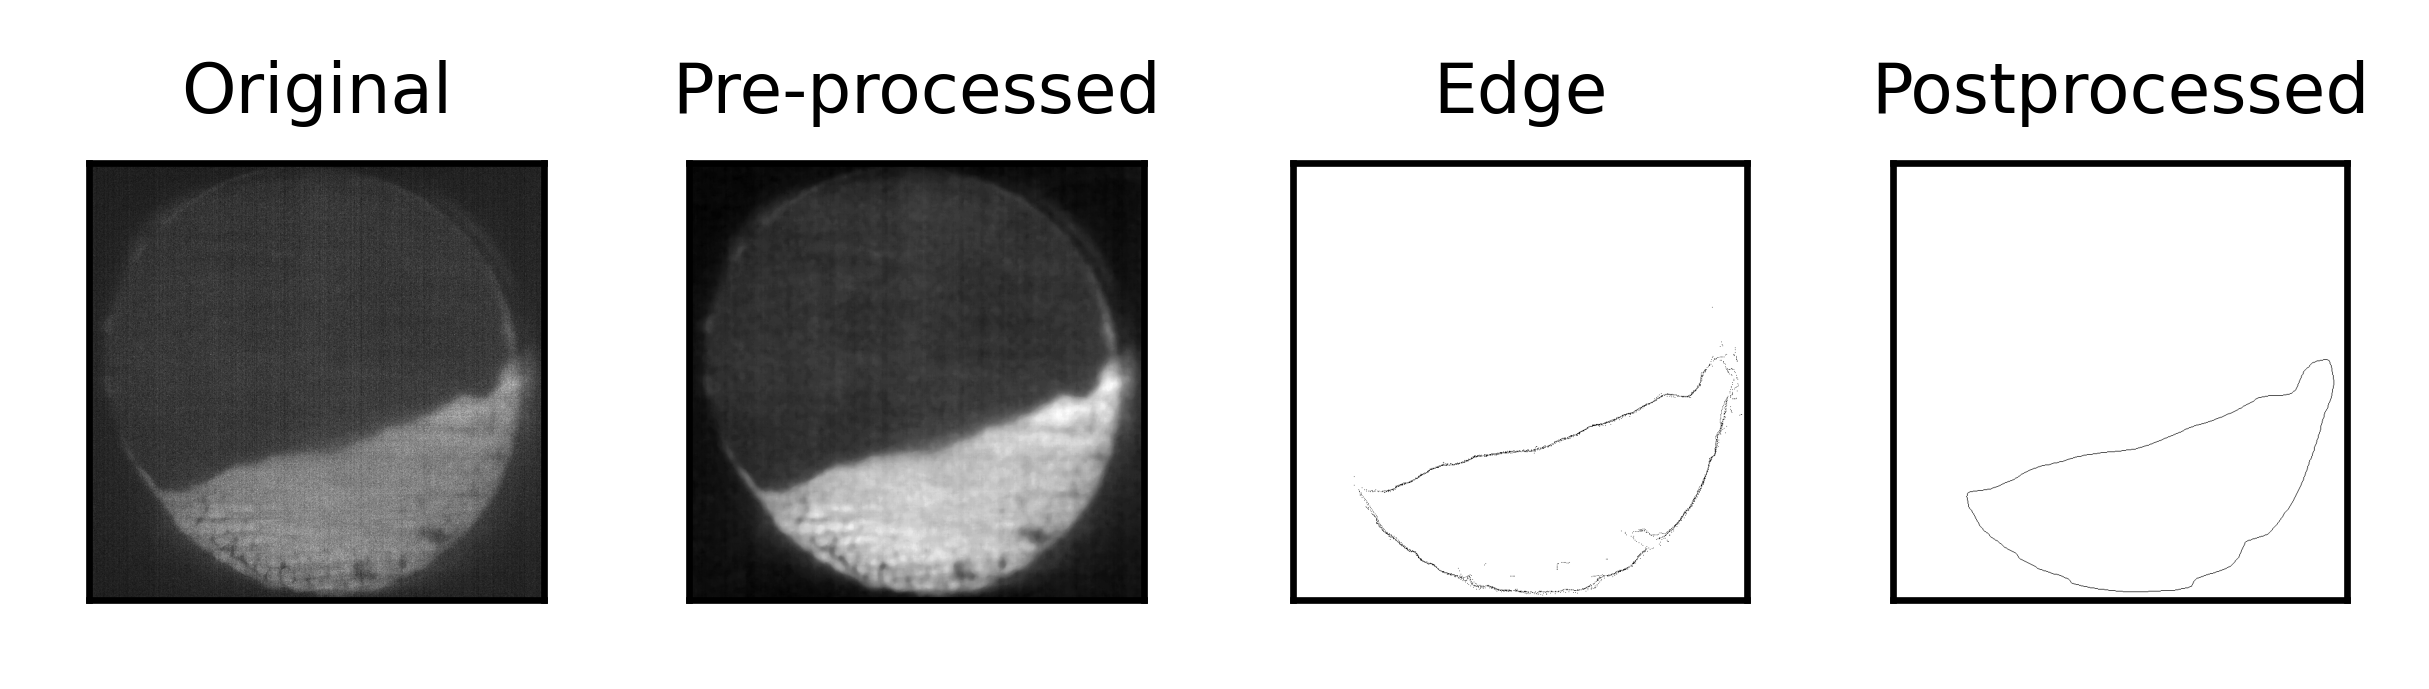

In [8]:
# Show results
fig, ax = plt.subplots(1,4, constrained_layout = True, figsize=(4, 1), dpi=600) # figsize: figure dimension (width, height) in inches.
ax[0].imshow(Iori, cmap='gray')
ax[0].set_title('Original',fontsize='small')
ax[1].imshow(Ien, cmap='gray')
ax[1].set_title('Pre-processed',fontsize='small')
ax[2].imshow(BW, cmap='gray_r')
ax[2].set_title('Edge',fontsize='small')
ax[3].imshow(BWlast, cmap='gray_r')
ax[3].set_title('Postprocessed',fontsize='small')

for i in np.arange(0,4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

/usr/local/lib/python3.8/dist-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


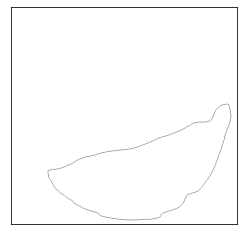

In [9]:
# Save contour
fig2, ax2 = plt.subplots()
ax2.imshow(BWlast,cmap='gray_r')
ax2.set_xticks([])
ax2.set_yticks([])
plt.ioff()
result_path = f"{project_path}result{sep}"
save_file = f"{result_path}edge.tif"
OmeTiffWriter.save(BWlast, save_file)